              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1595
           1       0.64      0.64      0.64       405

    accuracy                           0.86      2000
   macro avg       0.78      0.77      0.78      2000
weighted avg       0.86      0.86      0.86      2000

Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
ROC AUC score: 0.8697619876930223


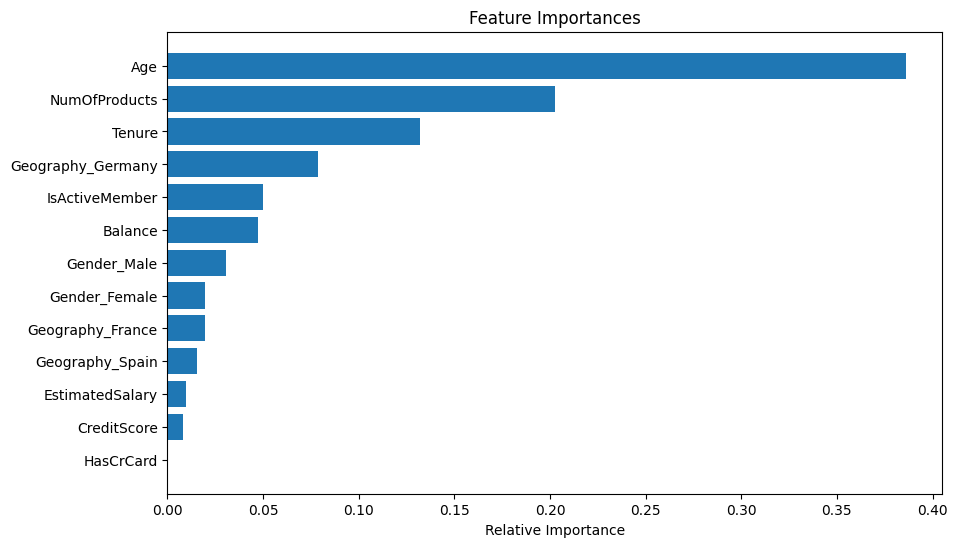

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('Churn_Modelling.csv')

# Data cleaning
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# Define features and target variable
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Create transformers for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the model: Trying Gradient Boosting
model = GradientBoostingClassifier(random_state=0)

# Create the imbalanced pipeline with SMOTE
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=0)),
    ('model', model)
])

# Hyperparameter tuning
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5]
}

search = GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring='roc_auc', cv=5)

search.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, search.predict_proba(X_test)[:, 1])
print('Best Params:', search.best_params_)
print('ROC AUC score:', roc_auc)

# Visualizing feature importances (after fitting the model with best parameters)
ohe = (search.best_estimator_.named_steps['preprocessor']
       .named_transformers_['cat'])
feature_names = ohe.get_feature_names_out(input_features=categorical_cols)
feature_names = np.r_[numerical_cols, feature_names]

# Get feature importances
importances = search.best_estimator_.named_steps['model'].feature_importances_
sorted_idx = np.argsort(importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()
